# 📌Intro.

- 이번 프로젝트는 GAN을 학습하며 배웠던 DCGAN의 모델구조를 기반으로 CIFAR-10 데이터를 생선하는 모델을 만드는 것 입니다.
- 목표는 기본적인 DCGAN모델을 만들고 데이터를 생성하는 과정을 모니터링 할 수 있는 시스템을 만드는 것입니다.
- 또한, 생성된 모델의 학습과정 및 결과물을 기반으로 모델구조나 학습 과정을 개선한 결과물을 제출하는 것을 추가적인 목표로 진행합니다.

# STEP1. 작업환경 구성하기

In [1]:
import tensorflow as tf
import imageio

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

```python
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

으로 작업환경을 기본설정해두고 생성된 이미지결과, 모델, 학습 history를 저장해두고 필요에 따라 꺼내서 활용하도록 세팅했습니다.

### 코드 재실행을 고려한 이전 학습 결과 관리 함수

In [4]:
import zipfile
import shutil

# 각 경로 설정
generated_samples_path = os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/generated_samples")
training_checkpoints_path = os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/training_checkpoints")
training_history_path = os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/training_history")

# 압축 파일 생성 함수
def create_zip_file(source_directory, target_directory):
    # 현재 시각을 이용하여 압축 파일 이름 생성 (yymmddhhmm 형태)
    import time
    current_time = time.strftime("%y%m%d%H%M")
    zip_file_name = f"{target_directory}/data_{current_time}.zip"

    # 기존에 해당 파일이 있는지 확인
    if os.path.exists(zip_file_name):
        print(f"압축 파일 {zip_file_name} 이미 존재합니다.")
        return

    # 압축 파일 생성
    with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_directory):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), source_directory))

    # 압축에 사용된 파일 삭제
    shutil.rmtree(source_directory)

    print(f"압축 파일 {zip_file_name} 생성 및 사용된 파일 삭제 완료")

In [36]:
# 각 경로에 대해 압축 파일 생성 함수 호출
create_zip_file(generated_samples_path, os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/"))
create_zip_file(training_checkpoints_path, os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/"))
create_zip_file(training_history_path, os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/"))

압축 파일 /aiffel/aiffel/dcgan_newimage/cifar10//data_2401230725.zip 생성 및 사용된 파일 삭제 완료
압축 파일 /aiffel/aiffel/dcgan_newimage/cifar10//data_2401230725.zip 이미 존재합니다.
압축 파일 /aiffel/aiffel/dcgan_newimage/cifar10//data_2401230725.zip 이미 존재합니다.


# STEP 2. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 불러온 데이터의 값의 범위를 확인합니다.

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


- 불러온 이미지는 RGB형태의 이미지 데이터로 0~255사이의 값을 가집니다.

In [5]:
# 이미지 데이터를 [0.0, 1.0] 범위로 정규화
train_x = train_x / 255.0


print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: 0.0


In [6]:
# 학습할 이미지의 shape를 확인합니다.
print("train_x의 모양:", train_x.shape)

train_x의 모양: (50000, 32, 32, 3)


### 전처리된 학습 데이터 시각화

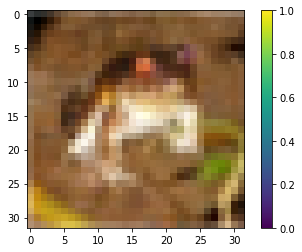

In [7]:
# 첫 번째 RGB 이미지 데이터를 그대로 표시
plt.imshow(train_x[0])
plt.colorbar()  # 컬러바 추가
plt.show()

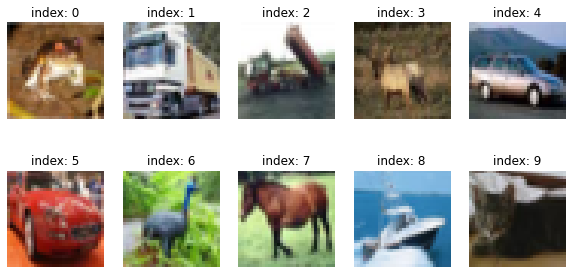

In [8]:
# 그림판 크기 설정
plt.figure(figsize=(10, 5))

# 2x5 그리드에 이미지를 출력
for i in range(10):
    plt.subplot(2, 5, i+1)  # 2행 5열 그리드 중 현재 위치 설정
    plt.imshow(train_x[i])  # 이미지를 그대로 표시
    plt.title(f'index: {i}')  # 이미지 제목에 인덱스 출력
    plt.axis('off')  # 축을 비활성화하여 이미지 주변의 불필요한 축 제거

# 이미지 그리기
plt.show()

### Tensorflow Dataset 준비

In [9]:
# 데이터셋 경로 설정 (CIFAR-10 데이터셋 경로에 맞게 설정)
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# 데이터 전처리 (0~255 범위의 정수를 0~1 범위의 부동소수점으로 변환)
train_images = train_images / 255.0

# 데이터셋 파라미터 설정
BUFFER_SIZE = 50000  # 데이터를 섞을 버퍼 크기 (CIFAR-10 훈련 데이터 수)
BATCH_SIZE = 256    # 배치 크기

# tf.data.Dataset을 사용하여 훈련 데이터셋을 생성
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 3. 생성자 모델 구현하기

## Generator(생성자) Model 함수

In [10]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(100,)))  # 4x4x256 유닛, 편향 없음, 입력 차원은 100
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.LeakyReLU())  # LeakyReLU 활성화 함수

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))  # 레이어 형태를 4x4x256으로 재구성

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))  # 128 필터, 5x5 커널, stride 2, 패딩 사용, 편향 없음
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.LeakyReLU())  # LeakyReLU 활성화 함수

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))  # 64 필터, 5x5 커널, stride 2, 패딩 사용, 편향 없음
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.LeakyReLU())  # LeakyReLU 활성화 함수

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # 3 필터(RGB), 5x5 커널, stride 2, 패딩 사용, 편향 없음, tanh 활성화 함수

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

- model = tf.keras.Sequential(): 이 코드는 Sequential 모델을 생성하는 부분입니다. Sequential 모델은 여러 레이어를 연속적으로 쌓아 올리는 모델입니다. 이 모델은 CIFAR-10 이미지를 생성하는 데 사용됩니다.

- model.add(layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(100,))): 첫 번째 레이어로 Dense 레이어를 추가합니다. 이 레이어는 100차원의 잠재 공간 벡터를 입력으로 받아, CIFAR-10 이미지와 유사한 특징을 학습하기 위한 4x4x256 크기의 레이어를 생성합니다. 편향(bias)은 사용되지 않습니다.

- model.add(layers.BatchNormalization()): 배치 정규화를 추가합니다. 이것은 모델의 안정성을 높이고 학습을 원할하게 만들어 주는 중요한 요소입니다.

- model.add(layers.LeakyReLU()): LeakyReLU 활성화 함수를 추가합니다. 이 함수는 음수 값에 대해 작은 기울기를 가지므로, 모델이 다양한 특징을 학습하고 다양한 이미지를 생성할 수 있도록 도와줍니다.

- model.add(layers.Reshape((4, 4, 256))): 이 부분에서는 레이어의 형태를 4x4x256으로 재구성합니다. 이것은 다음 단계에서 Conv2DTranspose를 사용하여 이미지 크기를 키우기 위한 준비 단계입니다.

- model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)): 두 번째 레이어로 Conv2DTranspose 레이어를 추가합니다. 이 레이어는 128개의 필터를 가지며, 5x5 크기의 커널과 stride를 2로 설정하여 이미지를 확대합니다. 'same' 패딩은 출력 이미지 크기를 입력과 동일하게 유지합니다. 편향은 사용되지 않습니다.

- model.add(layers.BatchNormalization()): 배치 정규화를 다시 추가합니다.

- model.add(layers.LeakyReLU()): LeakyReLU 활성화 함수를 다시 추가합니다.

- model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)): 세 번째 레이어로 Conv2DTranspose 레이어를 추가합니다. 이 레이어는 64개의 필터를 가지며, 이전 레이어와 동일한 설정을 가집니다.

- model.add(layers.BatchNormalization()): 다시 배치 정규화를 추가합니다.

- model.add(layers.LeakyReLU()): LeakyReLU 활성화 함수를 다시 추가합니다.

- model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')): 마지막 레이어로 Conv2DTranspose 레이어를 추가합니다. 이 레이어는 3개의 필터를 가지며, RGB 이미지를 생성하기 위한 레이어입니다. 5x5 크기의 커널과 stride를 2로 설정하여 이미지를 확대하고, tanh 활성화 함수를 사용하여 픽셀 값을 -1에서 1 사이로 조정합니다.

## Generator model 작동 확인(w.랜덤 노이즈)

In [12]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
noise = tf.random.normal([1, 100])

In [13]:
# 노이즈 벡터가 적용된 생정자의 결과물 확인
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

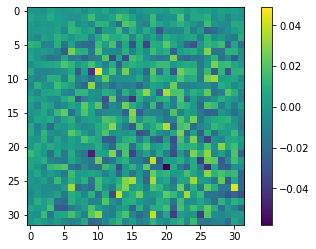

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# STEP 4. 판별자 모델 구현하기

## Discriminator(판별자) Model 함수

In [15]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))  # 64 필터, 5x5 커널, stride 2, 패딩 사용, 입력 크기 32x32x3
    model.add(layers.LeakyReLU())  # LeakyReLU 활성화 함수 적용
    model.add(layers.Dropout(0.3))  # 0.3 드롭아웃 적용

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))  # 128 필터, 5x5 커널, stride 2, 패딩 사용
    model.add(layers.LeakyReLU())  # LeakyReLU 활성화 함수 적용
    model.add(layers.Dropout(0.3))  # 0.3 드롭아웃 적용

    # Third: Flatten Layer
    model.add(layers.Flatten())  # 데이터를 1차원으로 평탄화

    # Fourth: Dense Layer
    model.add(layers.Dense(1))  # 출력 레이어, 하나의 유닛을 가짐

    return model

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [17]:
# 가짜(노이즈로 만든) 이미지를 테스트

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00066171]], dtype=float32)>

- shape가 (1, 1)이고 데이터 타입이 float32인 텐서형태의 결과물을 출력하고 있습니다.

# STEP 5. 손실함수와 최적화 함수 구현하기

- Generator와 Discriminator의 손실함수를 구현합니다.
- Discriminator의 출력값을 기반으로 real/fake 이미지를 판별하고 accuracy를 계산하는 함수를 구현합니다.
- Generator와 Discriminator를 최적화 하는 optimizer를 정의합니다.

---

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss 함수

In [19]:
# generator_loss 함수
def generator_loss(fake_output):
    # fake_output과 1 사이의 교차 엔트로피 손실 계산
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss 함수

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 판별자(Discriminator)의 정확도 계산 함수

In [21]:
def discriminator_accuracy(real_output, fake_output):
    # 실제 이미지 정확도 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    
    # 가짜 이미지 정확도 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

### Optimizer 설정

In [22]:
# 생성자(Generator) 옵티마이저 설정
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# 판별자(Discriminator) 옵티마이저 설정
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# STEP 6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

### train_step 설정

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # 생성자 입력 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 생성자를 통해 가짜 이미지 생성

        real_output = discriminator(images, training=True)  # 판별자로 실제 이미지 분류
        fake_output = discriminator(generated_images, training=True)  # 판별자로 가짜 이미지 분류

        gen_loss = generator_loss(fake_output)  # 생성자 손실 계산
        disc_loss = discriminator_loss(real_output, fake_output)  # 판별자 손실 계산

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)  # 실제 및 가짜 이미지에 대한 판별자 정확도 계산
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # 생성자의 기울기 계산
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # 판별자의 기울기 계산

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # 생성자 가중치 업데이트
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # 판별자 가중치 업데이트

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # 계산된 손실과 정확도 반환

### 훈련 과정 동안 생성한 이미지를 시각화하는 함수

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        image = (predictions[i] + 1) / 2  # -1~1 범위를 0~1 범위로 변환
        plt.imshow(image)
        plt.axis('off')
   
    # 생성된 이미지를 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(os.getenv('HOME'), epoch, it))

    # 생성된 이미지 표시
    plt.show()

### 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화 함수

- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 12

def draw_train_history(history, epoch):
    
    plt.subplots_adjust(hspace=1)  # 하위 그래프 간격 조절
    
    # 그래프의 크기를 설정합니다.
    plt.subplot(211)
    
    # 생성자와 판별자의 손실 그래프를 그립니다.
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    
    # 그래프 제목과 축 라벨을 설정합니다.
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Batch Iterations')
    
    # 범례를 설정합니다.
    plt.legend(['Generator Loss', 'Discriminator Loss'], loc='upper left')

    plt.subplot(212)
    
    # 가짜 이미지와 진짜 이미지 판별 정확도 그래프를 그립니다.
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    
    # 그래프 제목과 축 라벨을 설정합니다.
    plt.title('Discriminator Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Batch Iterations')
    
    # 범례를 설정합니다.
    plt.legend(['Fake Image Accuracy', 'Real Image Accuracy'], loc='upper left')

    # 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                .format(os.getenv('HOME'), epoch))
    
    # 그래프를 표시합니다.
    plt.show()

### checkpoint 모듈

- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈

In [26]:
# 체크포인트 디렉토리 설정
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# 체크포인트 파일 이름 설정
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 체크포인트 객체 생성
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 최종 학습(train) 함수

In [39]:
from IPython import display

def train(dataset, epochs, save_every):
    # 학습 시작 시간 기록
    start = time.time()
    # 손실 및 정확도 기록을 위한 딕셔너리 초기화
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()  # 에폭 시작 시간 기록

        for it, image_batch in enumerate(dataset):
            # train_step 함수를 호출하여 각 배치에 대한 손실 및 정확도 계산
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 50번째 반복마다 이미지 생성 및 출력
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # 지정된 save_every 에폭마다 체크포인트 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 에폭 종료 시 이미지 생성 및 출력
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        # 학습 기록 그래프로 그리기
        draw_train_history(history, epoch)

# STEP 7. 학습 과정 진행하기

### 샘플 이미지 생성

In [28]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [29]:
save_every = 5
EPOCHS = 200 

num_classes = 10 # CIFAR-10의 레이블 수

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

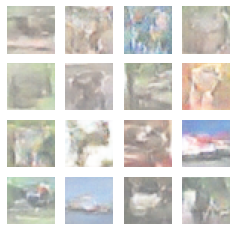

Time for training : 3430 sec


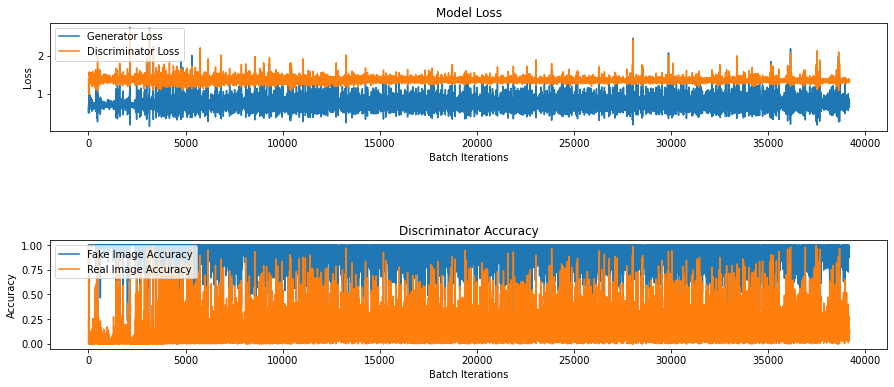

CPU times: user 58min 9s, sys: 5min 24s, total: 1h 3min 33s
Wall time: 57min 12s


In [36]:
%%time

train(train_dataset, EPOCHS, save_every)

## 학습결과 검토하기

### 학습과정 GIF로 시각화 하기

In [30]:
def generate_and_save_gif(anim_dir):
    timestamp = int(time.time())  # 현재 시간을 기반으로 타임스탬프 생성
    anim_file = os.path.join(anim_dir, f'cifar10_dcgan_{timestamp}.gif')

    with imageio.get_writer(anim_file, mode='I') as writer:
        # 생성된 이미지 파일들의 경로를 가져옵니다.
        filenames = glob.glob(f'{anim_dir}/generated_samples/sample*.png')
        # 파일 이름을 정렬합니다.
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            # GIF 프레임 간격 설정
            frame = 2 * (i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            # 이미지 파일을 읽어와 GIF에 추가합니다.
            image = imageio.imread(filename)
            writer.append_data(image)
        # 마지막 이미지를 GIF에 추가합니다.
        image = imageio.imread(filename)
        writer.append_data(image)

    # 생성된 GIF 파일 확인
    print(f'Generated GIF: {anim_file}')

In [ ]:
# 함수 실행
anim_dir = os.path.join(os.getenv('HOME'), 'aiffel/dcgan_newimage/cifar10')
generate_and_save_gif(anim_dir)

In [32]:
import base64
from IPython.display import display, HTML

def list_and_visualize_gifs(directory):
    # 지정된 디렉토리에서 GIF 파일들을 찾습니다.
    gif_files = glob.glob(os.path.join(directory, '*.gif'))
    
    # GIF 파일들의 리스트를 출력합니다.
    print("Available GIF files:")
    for i, gif_file in enumerate(gif_files):
        print(f"{i + 1}: {os.path.basename(gif_file)}")
    
    # 시각화할 GIF 파일 선택
    while True:
        try:
            choice = int(input("Enter the number of the GIF file to visualize (0 to exit): "))
            if choice == 0:
                return
            elif 1 <= choice <= len(gif_files):
                chosen_gif = gif_files[choice - 1]
                break
            else:
                print("Invalid choice. Please enter a valid number or 0 to exit.")
        except ValueError:
            print("Invalid input. Please enter a valid number or 0 to exit.")
    
    # 선택한 GIF 파일을 움짤로 시각화
    with open(chosen_gif, 'rb') as f:
        display(HTML(f'<img src="data:image/gif;base64,{base64.b64encode(f.read()).decode()}" />'))

Available GIF files:
1: cifar10_dcgan_1705995064.gif
2: cifar10_dcgan_1705982298.gif
3: cifar10_dcgan_1705986131.gif
4: cifar10_dcgan_1705994118.gif
Enter the number of the GIF file to visualize (0 to exit): 3



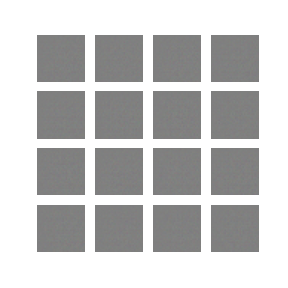

In [33]:
# 함수 실행
gif_dir = os.path.join(os.getenv('HOME'), 'aiffel/dcgan_newimage/cifar10')
list_and_visualize_gifs(gif_dir)

- 총 200의 epoch를 학습시켰는데, 모델이 학습을 진행함에 따라 점점 CIFAR-10과 비슷한 이미지들을 생성해 내는 것을 볼 수 있습니다.
- 이미지만으로도 아직 충분히 정확한 데이터셋을 생성해 내는 것은 아니라는 것을 확인할 수 있습니다.

### check point로 결과 불러오기 및 생성

- 이미 gif에서 어느정도 확인이 가능하지만 가장 최근의 checkpoint 모델을 불러와서 이미지를 직접 생성해 보겠습니다.

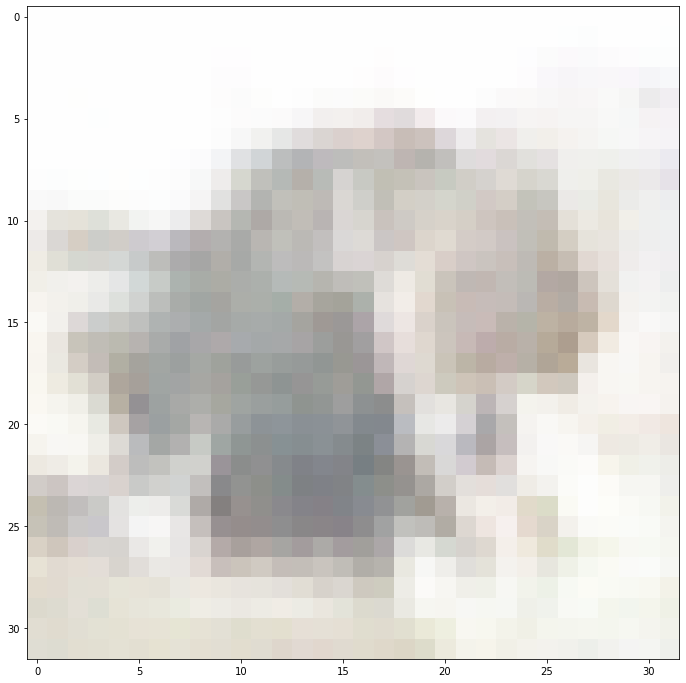

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

- gif에서도 확인했지만 아직까진 정확이미지를 생성해내지는 못하고 있습니다.
- 다만 점차 나아지고 있는 것은 확실해 보입니다.
- 가장 마지막 epoch의 history 그래프를 다시 확인해 보겠습니다.

### 이미지 판별 accuracy 히스토리(history) 그래프 확인하기

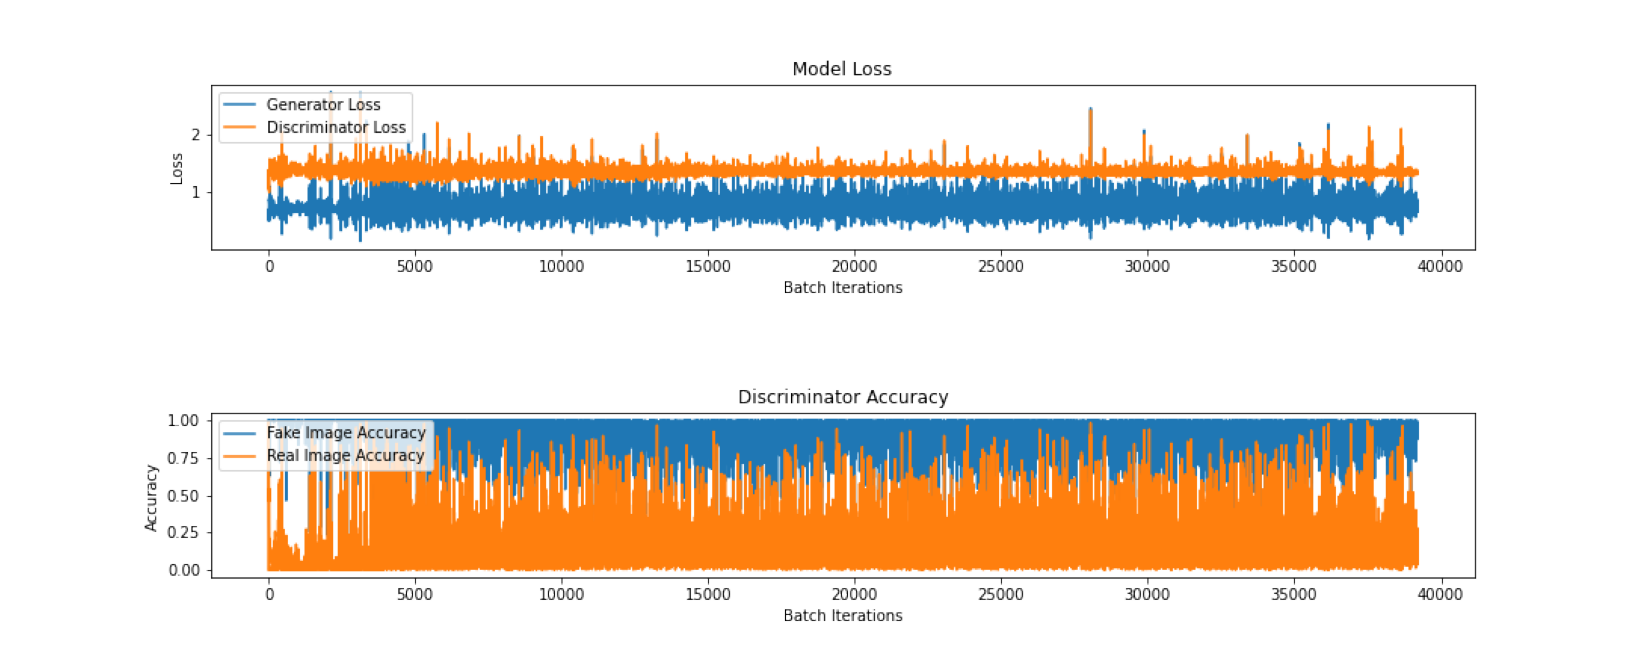

In [35]:
from PIL import Image

# training_history_path: 저장된 훈련 히스토리 이미지 파일이 있는 디렉토리 경로
training_history_path = os.path.expanduser("~/aiffel/dcgan_newimage/cifar10/training_history")

# 해당 디렉토리 내의 이미지 파일을 모두 가져옵니다.
image_files = glob.glob(os.path.join(training_history_path, "*.png"))

# 이미지 파일을 파일 수정 시간 기준으로 정렬합니다.
image_files.sort(key=os.path.getmtime)

# 가장 최근에 수정된 이미지 파일 경로를 가져옵니다.
latest_image_path = image_files[-1]

# 이미지를 불러와서 시각화합니다.
latest_image = Image.open(latest_image_path)
plt.imshow(latest_image)
plt.axis('off')
plt.show()

- 학습 과정에서 두 손실 값은 일반적으로 서로 반대 방향으로 움직입니다. 
    - 즉, 생성자의 손실이 낮아지면 판별자의 손실이 높아지는 경향이 있습니다. 
    - 그러나 이상적인 GAN 학습에서는 두 모델이 균형을 이루며 서로를 발전시키는 경쟁을 하게 됩니다.
    
---

- 이 그래프를 보면, 학습이 진행됨에 따라 생성자와 판별자의 손실이 점차 안정되는 경향을 보이고, 판별자의 정확도가 일정한 범위 안에서 변동하고 있음을 알 수 있습니다. 
- 이는 GAN이 학습을 진행하며 어느 정도 균형을 찾아가고 있음을 시사합니다. 
- 그러나 완벽한 균형을 찾기 위해서는 더 많은 실험과 조정이 필요해 보입니다.
- 이러한 판단 근거는 아래와 같습니다.

---

- 모델 손실 안정성
    - 완벽한 균형상태에 도달하기 위해서는 생성자와 판별자의 loss가 모두 시간이 지남에 따라 안정되어야 합니다.
    - 하지만 그래프를 보면 손실값이 둘다 불규칙적으로 fluctuating 하고 있음을 알 수 있습니다.
    
- 손실값의 수렴
    - 이상적인 GAN의 학습이 이뤄진다면 생성자와 판별자의 손실이 특정 값으로 수렴해야 합니다.
    - 하지만 현재 그래프에서는 손실이 수렴하지 못하고 있음을 알 수 있습니다.

- 판별자의 정확도
    - 판별자의 정확도는 판별자가 가짜 이미지와 진짜 이미지를 얼마나 잘 구별하는지에 대한 성능을 나타냅니다.
    - 이상적인 GAN 학습이 이뤄진다면 정확도가 높고 안정적이어야 합니다.
    - 하지만 그래프를 보면 정확도가 fluctuating 하고 있습니다. 특히, 가짜 이미지에 대한 정확도가 높아야 하지만 epoch가 지날수록 크게 변동하고 있습니다.

- 균형 상태의 달성 여부
    - GAN 기반 모델의 학습 목적은 결국 생성자와 판별자가 서로 속일 수 있는 상태(=균형상태) 에 도달하는 것입니다.
    - 이 균형상태에 도달하면 손실, 정확도 그래프 모두에서 안정적인 패턴을 보여줘야 합니다.

# STEP 8. (optional) GAN 훈련 과정 개선하기

- GAN 모델의 성능 개선을 위해 참고 가능한 레퍼런스 자료들은 아래와 같습니다.

    - [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)

    - [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
    - [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
    - [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)
    
---
   
- paper를 제거하고 위 3개의 레퍼런스의 방법들을 정리해보자면 아래와 같습니다.

---
- **GAN 모델 성능 향상 방법**

- 데이터 품질 관리
    - 데이터의 품질과 다양성이 모델의 성능에 큰 영향을 미칩니다. 따라서 적절한 데이터 전처리와 데이터의 다양성 확보가 중요합니다.
- 모델 복잡성 조절
    - 복잡한 모델이 항상 더 좋은 결과를 내는 것은 아닙니다. 
    - 간단한 모델부터 시작하여 점진적으로 복잡성을 높여나가는 것이 좋습니다.
- 생성기와 판별기의 균형 유지
    - 너무 강력한 판별기는 생성기의 학습을 방해할 수 있으므로, 두 네트워크 간 균형 유지가 중요합니다.
- 적절한 학습률 설정
    - 너무 높거나 낮은 학습률은 학습을 방해할 수 있습니다. 
    - 일반적으로 권장되는 학습률을 사용하고, 필요에 따라 조정하는 것이 좋습니다.
- 생성기와 판별기의 업데이트 비율 조절
    - 네트워크 간 학습 속도의 균형을 유지하기 위해 생성기와 판별기의 업데이트 비율을 조절합니다.
- 소프트 레이블 및 노이즈 추가
    - 실제 샘플에 대한 타겟을 1.0이 아닌 0.9와 같이 더 작은 값으로 설정하거나, 디스크리미네이터의 입력에 노이즈를 추가하여 모델의 강인성을 향상시킬 수 있습니다.
- 배치 정규화 및 드롭아웃 사용
    - 네트워크의 각 층에서 출력을 표준화하여 학습 속도를 높이고, 더 나은 결과를 만들어냅니다. 또한, 오버피팅을 막기 위해 드롭아웃을 사용할 수 있습니다.
- 가우시안 노이즈 사용
 - 생성기의 입력으로 가우시안 분포에서 추출한 노이즈를 사용하여 다양성을 높이고, 모델의 안정성을 향상시킵니다.

### 적용가능한 개선방안

- 생성자의 초기 입력 차원 조정: 생성자에 입력되는 노이즈 벡터의 차원을 조정하여 모델이 더 복잡한 패턴을 학습할 수 있도록 할 수 있습니다. 현재 100으로 설정되어 있는데, 이를 늘리거나 줄여보며 실험해 볼 수 있습니다.

- 드롭아웃 비율 조정: 판별자에 적용된 드롭아웃 비율이 0.3으로 설정되어 있습니다. 학습 과정에서의 변동성을 고려하여 이 비율을 조정해 볼 수 있습니다. 너무 높은 드롭아웃은 판별자의 학습 능력을 저하시킬 수 있으므로 적절한 비율을 찾는 것이 중요합니다.

- 학습률과 옵티마이저 조정: 현재 설정된 학습률과 사용 중인 옵티마이저에 대한 정보가 없으므로, 이 부분에 대한 조정도 고려해 볼 수 있습니다. 예를 들어, Adam 옵티마이저의 학습률을 낮추거나, beta1과 beta2 파라미터를 조정하여 안정적인 학습을 도모할 수 있습니다.

- 학습 일정(scheduler) 적용: 학습 과정에서 학습률을 동적으로 조정하기 위해 학습률 스케줄러를 적용해 볼 수 있습니다. 이를 통해 초기에는 빠른 학습률로 시작하여 점차 학습률을 감소시켜 최적의 수렴을 찾아갈 수 있습니다.

- 데이터 증강 적용: CIFAR-10은 상대적으로 데이터셋의 크기가 작기 때문에, 데이터 증강을 통해 더 다양한 데이터를 생성하여 모델의 일반화 능력을 향상시킬 수 있습니다. 예를 들어, 이미지를 회전시키거나, 수평으로 뒤집는 등의 방법을 적용해 볼 수 있습니다.

- 모델 복잡도 조정: 생성자와 판별자의 네트워크가 현재 CIFAR-10의 다양한 이미지를 잘 학습하고 있는지 평가해보고, 필요하다면 더 많은 합성곱 층을 추가하거나 제거하여 복잡도를 조절할 수 있습니다.

- 손실 함수 검토: 현재 사용하고 있는 손실 함수가 모델에 적합한지 검토해 보고, 필요하다면 다른 GAN 손실 함수로 실험해 볼 수 있습니다. 예를 들어, LSGAN이나 WGAN의 손실 함수를 적용해 볼 수 있습니다.

## 학습률 조정 

- 일단은 체크포인트를 통해 하이퍼 파라미터 수정이 가능한 부분에 대한 실험을 진행해 보겠습니다.
- 일단 위에서 불러왔었던 check point의 생성자와 판별자를 불러와서 사용하겠습니다.

```python
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator
```

---

- 드롭아웃이나 모델 성능 조정등은 모델 자체의 구조를 바꿔야 하기 때문에 당장 적용이 어려울 것 같습니다.
- 여기서 조정이 가능한 부분은 학습률 조정이 가장 손쉬운 방법이 될 것입니다.
- 학습률을 다양하게 적용해보기 위해 학습률 스케줄러를 사용해서 다양한 학습률을 적용해보겠습니다.

#### train 함수 조정

In [44]:
# 학습률 스케줄링 함수 정의
def scheduler(epoch):
    if epoch < 10:
        return 2e-4
    else:
        return 2e-4 * tf.math.exp(-0.1 * (epoch - 10))

def train(dataset, epochs, save_every):
    # 초기 학습률 설정
    learning_rate = 2e-4

    # 학습 시작 시간 기록
    start = time.time()

    # 손실 및 정확도 기록을 위한 딕셔너리 초기화
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        # 각 에폭마다 학습률 업데이트
        learning_rate = scheduler(epoch)
        generator_optimizer.lr.assign(learning_rate)
        discriminator_optimizer.lr.assign(learning_rate)

        epoch_start = time.time()  # 에폭 시작 시간 기록

        for it, image_batch in enumerate(dataset):
            # train_step 함수를 호출하여 각 배치에 대한 손실 및 정확도 계산
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 50번째 반복마다 이미지 생성 및 출력
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # 지정된 save_every 에폭마다 체크포인트 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 에폭 종료 시 이미지 생성 및 출력
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        # 학습 기록 그래프로 그리기
        draw_train_history(history, epoch)

In [45]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)  # 생성자 학습률을 2e-4에서 1e-4로 조정
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)  # 판별자 학습률을 2e-4에서 1e-4로 조정

In [46]:
save_every = 5
EPOCHS = 50 # 성능만 확인 

num_classes = 10 # CIFAR-10의 레이블 수

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 회고


## KEEP
- 모델을 구현해서 1 cycle 을 돌리면서 대략적인 이해도를 높였다.
- 모델 학습 결과를 기반으로 평가를 하고, 개선방안에 대한 방안을 구상했다.
- Improved Techniques for Training GANs 에서 제안한 방안을 찾아보고 정리했다.

## PROBLEM
- 시간내에 1 cycle밖에 돌리지 못하고 개선책을 적용해보지 못했다.
- Improved Techniques for Training GANs 에서 제안한 방안을 정리했으나 적용을 위한 코드 구현을 하지 못했다.

## TRY
- Improved Techniques for Training GANs 에서 제안한 방안 적용해보기
- 구상한 개선방안 시도해보고 업데이트하기